# SREIO 2019 Data Preprocessing fro Transfofrmer Model

In [228]:
import os
import sys
import json
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import random
from IPython import display
from PIL import Image
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from matplotlib.pyplot import imshow
import math
%matplotlib inline


In [229]:
# this is where I have downlaoded the raw dataset
! ls ../../data/SROIE2019

0325updated.task1train(626p) test.txt
0325updated.task2train(626p) text.task1_2-test（361p)
SroieNERDataset.ipynb        train.txt
task1_2_test(361p)           valid.txt
task3-test 347p) -


In [230]:
DATA_ROOT_PATH = "../../data/SROIE2019" # point this to your local or colab path!

In [231]:
# Get list of all image files with relative path
img_files = os.listdir(DATA_ROOT_PATH + "/0325updated.task1train(626p)")
img_files = list(map(lambda file: DATA_ROOT_PATH + "/0325updated.task1train(626p)/" + file, img_files))
img_files = [file for file in img_files if file.endswith(".jpg")]
img_files = {file.split("/")[-1].split(".")[0] : file for file in img_files}

In [232]:
def get_text_file_dicts(directory):
    """
    List all the files in the directory and filter .txt files
    
    return:
        dict : {file_name_without_extension : relative_path}
    """
    res = defaultdict(None)
    all_files = os.listdir(directory)
    text_files = [file for file in all_files if file.endswith(".txt")]
    text_files = list(map(lambda file: directory + "/" + file, text_files))
    for file in text_files:
        key = file.split("/")[-1].split(".")[0] # extract file name
        res[key]= file
            
    return res

In [383]:
def normalize_bbox(bbox, image):
    width, height = image.size
    
#     return [
#          int(1000 * (bbox[0] / width)),
#          int(1000 * (bbox[1] / height)),
#          int(1000 * (bbox[2] / width)),
#          int(1000 * (bbox[3] / height)),
#      ]
    res = [
         math.ceil(1000 * (bbox[0] / width)),
         math.ceil(1000 * (bbox[1] / height)),
         math.ceil(1000 * (bbox[2] / width)),
         math.ceil(1000 * (bbox[3] / height)),
     ]
    if not all(i <= 1000 for i in res):
        print(image.filename, width, height, bbox, res)
    return res

image = Image.open('../../data/SROIE2019/0325updated.task1train(626p)/X51008123451.jpg')

normalize_bbox([457, 156, 625, 193], image), normalize_bbox([160, 1173, 554, 1212], image)

([611, 123, 836, 152], [214, 923, 741, 954])

In [384]:
def unnormalize_bbox(bbox, image):
    # [457, 156, 625, 193] -> [611, 123, 836, 152]
    # [611, 123, 836, 152] -> [457, 156, 625, 193]
    width, height = image.size

    return [
         math.floor(bbox[0] / 1000 * width),
         math.floor(bbox[1] / 1000 * height),
         math.floor(bbox[2] / 1000 * width),
         math.floor(bbox[3] / 1000 * height),
     ]


image = Image.open('../../data/SROIE2019/0325updated.task1train(626p)/X51008123451.jpg')
print(unnormalize_bbox((611, 123, 836, 152), image), unnormalize_bbox([214, 923, 741, 954], image))

[457, 156, 625, 193] [160, 1173, 554, 1212]


In [385]:
def get_bbox_line(line):
    xycoords = line.split(",")[:8]
    x1, y1, x2, y2, x3, y3, x4, y4 = xycoords
    return [int(x1), int(y1), int(x3), int(y3)]
    

In [386]:
def extract(ocr_text_file, ie_text_file, image_file):
    """
    Match the OCR text with key value pair from infromation extraction task
    """
    
    if ocr_text_file is None or ie_text_file is None or image_file is None:
        return None
    
    if not os.path.exists(ocr_text_file) or not os.path.exists(ie_text_file) or not os.path.exists(image_file):
        return None
    
    ocr_text_file_lines = open(ocr_text_file).readlines()
    image = Image.open(image_file)
    # extract bbox !!WARNING : Dataset OCR are for whole line and not for individual token!!
    bbox = list(map(lambda line: get_bbox_line(line), ocr_text_file_lines))
    bbox = list(map(lambda xy: normalize_bbox(xy, image), bbox))
    # extract the text from the line
    ocr_text_file_lines = list(map(lambda line: " ".join(line.split(",")[8:]).strip(), ocr_text_file_lines))
    # add default tag O to each line
    token_2_tag = {line : 'O' for line in ocr_text_file_lines}
    bbox_for_ner_tags = {line : xy for line, xy in zip(ocr_text_file_lines, bbox)}
    
    
    ie_text_file_lines = open(ie_text_file).readlines()
    ie_text_file_lines = "".join(ie_text_file_lines)
    # read the data as dict
    ie_data = json.loads(ie_text_file_lines)
    
    # print(ie_data)
    res = {}
    
    for ocr_text, v in token_2_tag.items():
        for tag, ner_text in ie_data.items():
            ner_text = ner_text.replace(",", "")
            
            # omit empty string lines and length less than 2
            if ocr_text != '' and len(ocr_text) > 2 and (ocr_text in ner_text or ner_text in ocr_text):
                token_2_tag[ocr_text] = tag
             
            # For those lines which have multiple tokens
            num_matches = 0 
            for token in ocr_text.split(" "):
                if token != '' and token in ner_text:
                    num_matches += 1
                    
            # make sure we find atleast 2 matches per line to tag that line with respective tag        
            if num_matches > 2:
                token_2_tag[ocr_text] = tag
                    
    return token_2_tag, bbox_for_ner_tags
    

In [387]:
def tagged_data_to_conll(ner_data: dict, bbox_data: dict):
    """
    Given dict of lines and tags, convert it into CoNLL format
    """
    if ner_data is None or bbox_data is None:
        return []
    
    res = []
    
    for text, tag in ner_data.items():
        bbox = bbox_data[text]
        for token in text.split(" "):
            res.append((token, tag.replace("\n", ""), bbox))
    return res

In [388]:
def draw_bbox(img_file, conll_data):
    img = Image.open(img_file)#.convert("RGBA")
#     img.putalpha(127)
    draw = ImageDraw.Draw(img)
    for token, tag, bbox in conll_data:
        if tag != 'O':
            bbox = unnormalize_bbox(bbox, img)
            draw.rectangle(bbox, outline='red', width=1)
            draw.text((bbox[0], bbox[1]), tag, font=ImageFont.truetype("Roboto-Light.ttf", 30), stroke_width=0, fill='red', spacing=10)
    
    if os.path.exists('/tmp/temp124.jpg'):
        os.remove('/tmp/temp124.jpg')
    img.save("/tmp/temp124.jpg")
    return display.Image("/tmp/temp124.jpg")


In [389]:
train_ocr_text_files_dict = get_text_file_dicts(DATA_ROOT_PATH + "/0325updated.task1train(626p)")
train_ie_text_files_dict = get_text_file_dicts(DATA_ROOT_PATH + "/0325updated.task2train(626p)")
files = sorted(train_ocr_text_files_dict.keys())

../../data/SROIE2019/0325updated.task1train(626p)/X51005757351(1).txt
../../data/SROIE2019/0325updated.task1train(626p)/X51005757351(1).jpg True


(703, 1328)
{'MR. D.I.Y. (M) SDN BHD': 'company', '(CO. REG :860671-D)': 'O', 'LOT 1851-A & 1851-B  JALAN KPB 6': 'address', 'KAWASAN PERINDUSTRIAN BALAKONG': 'address', '43300 SERI KEMBANGAN  SELANGOR': 'address', '(GST ID NO :000306020352)': 'O', '(IOI PUCHONG)': 'O', '-TAX INVOICE-': 'O', 'MULTIPURPOSE BROOM 737P W/4FT': 'O', '*S': 'O', 'WA16 - 24': 'O', '9555221300282': 'O', '2 X 6.50': 'O', '13.00': 'O', 'HOSE PUMP C88351#': 'O', 'KE23-33-53 - 12/120': 'O', '9074333': 'O', '1 X 1.90': 'O', '1.90': 'O', 'ITEM(S) : 2': 'O', 'QTY(S) : 3': 'O', 'TOTAL INCL. GST@6%': 'O', 'RM 14.90': 'total', 'CASH': 'O', 'RM 20.00': 'O', 'CHANGE': 'O', 'RM 5.10': 'O', 'GST @6% INCLUDED IN TOTAL': 'O', 'RM 0.84': 'O', '24-03-18 18:02 SHO1 ZJ86': 'date', 'T1 R000112043': 'O', 'OPERATOR TRAINEE CASHIER': 'O', 'EXCHANGE ARE ALLOWED WITHIN': 'O', '7 DAY WITH REC

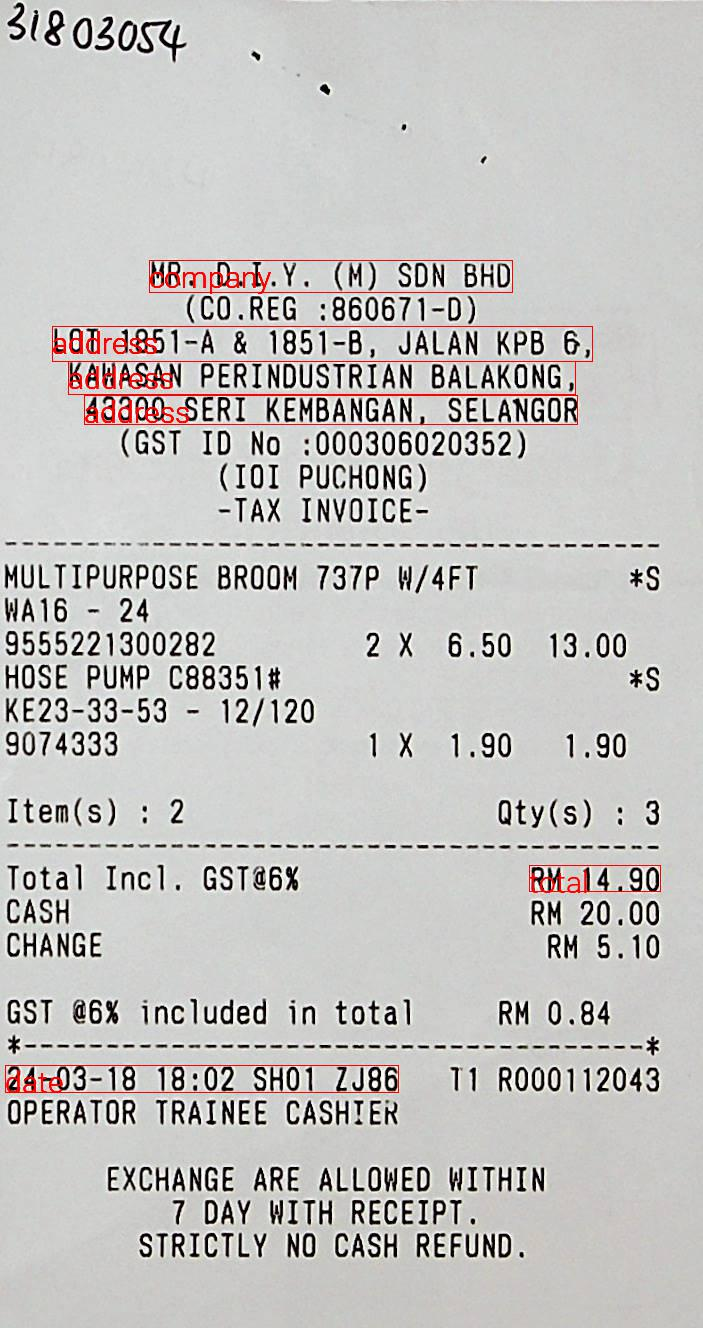

In [408]:
# key = 'X51005361897' #random.choice(list(train_ocr_text_files_dict.keys()))
key = random.choice(list(train_ocr_text_files_dict.keys()))
ocr_text_file = train_ocr_text_files_dict.get(key)
ie_text_file = train_ie_text_files_dict.get(key)
img_file = img_files.get(key.replace(".txt", ".jpg"))

print(ocr_text_file)


if img_file is None:
    print("Image file not found") 
    raise
    
print(img_file, os.path.exists(img_file))
print("\n")

print(Image.open(img_file).size)
token_2_tag, bbox_for_ner_tags = extract(ocr_text_file, ie_text_file, img_file)

print(token_2_tag)
print("\n\n")  
print(bbox_for_ner_tags)
print("\n\n") 

res = tagged_data_to_conll(token_2_tag, bbox_for_ner_tags)

for d in res:
    print(d)

# display.Image(img_file)

draw_bbox(img_file, res)

In [391]:
def create_data_file(file_path, files):
    res = []
    for file in tqdm(files):
        ocr_text_file = train_ocr_text_files_dict.get(file)
        ie_text_file = train_ie_text_files_dict.get(file)
        img_file = img_files.get(file.replace(".txt", ".jpg"))
        
#         print([ocr_text_file, ie_text_file, img_file])
        if None in [ocr_text_file, ie_text_file, img_file]:
            continue
            
        data = tagged_data_to_conll(*extract(ocr_text_file, ie_text_file, img_file))
        if data:
            res.append(data)

    is_first_record = True # hack to avoid empty new lines
    
    with open(file_path, "w") as file:
        for lines in res:
            if not is_first_record:
                file.write("\n\n")
                
            is_first_line = True   # hack to avoid empty new lines
            
            for line in lines:
                
                if not is_first_line:
                    file.write("\n")
                    
                line = list(line) # convert tuples to list
                line[2] = map(lambda t: str(t), line[2]) # map all xy coords to str
                line[2] = ",".join(line[2]) # convert list to string delimited by ','
                file.write(" ".join(list(line)))
                is_first_line = False
                
            is_first_record = False

In [392]:
! mkdir -p version1

# Prepare Datase

In [393]:
train_files = files[:700]
create_data_file(file_path="version1/train.txt", files=train_files)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 392.89it/s]


In [394]:
valid_files = files[700:750]
create_data_file(file_path="version1/valid.txt", files=valid_files)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 367.51it/s]


In [395]:
test_files = files[750:]
create_data_file(file_path="version1/test.txt", files=test_files)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 337.50it/s]


In [396]:
def validate(file_path):
    tags = set()
    num_lines = 0
    with open(file_path) as file:
        for line in file.readlines():
            num_lines += 1
            if len(line) > 1:
                tags.add(line.strip().split(" ")[-2])

    print(tags)
    print("Numebr of lines :", num_lines)

In [397]:
validate("version1/train.txt")

{'date', 'O', 'total', 'address', 'company'}
Numebr of lines : 61437


In [398]:
validate("version1/test.txt")

{'date', 'O', 'total', 'address', 'company'}
Numebr of lines : 7664


In [380]:
validate("version1/valid.txt")

{'date', 'O', 'total', 'address', 'company'}
Numebr of lines : 4599
